## Problem Statement

## **Context**
All Life Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. The Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help



## **Objective**
To identify different segments in the existing customers, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.



## **Data Description**
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online, and through a call center).

## **Data Dictionary**
**Sl_No**: Primary key of the records

**Customer Key**: Customer identification number

**Average Credit Limit**: Average credit limit of each customer for all credit cards

**Total credit cards**: Total number of credit cards possessed by the customer

**Total visits bank**: Total number of visits that the customer made (yearly) personally to the bank

**Total visits online**: Total number of visits or online logins made by the customer (yearly)

**Total calls made**: Total number of calls made by the customer to the bank or its customer service department (yearly)

## Importing necessary libraries

In [109]:
# this will help in making the Python code more structured automatically (good coding practice)
#%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to compute distances
from scipy.spatial.distance import pdist

## Reading the Dataset

In [110]:
# Read data from Excel file
# Loading the dataset - sheet_name parameter is used if there are multiple tabs in the excel file.
from google.colab import drive
drive.mount('/content/drive/') #/Colab_notebooks/Python_Files
# loading the dataset
data = pd.read_excel("/content/drive/My Drive/Colab_Notebooks/Credit Card Customer Data.xlsx")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Overview of the Dataset

The initial steps to get an overview of any dataset is to:
- observe the first few rows of the dataset, to check whether the dataset has been loaded properly or not
- get information about the number of rows and columns in the dataset
- find out the data types of the columns to ensure that data is stored in the preferred format and the value of each property is as expected.
- check the statistical summary of the dataset to get an overview of the numerical columns of the data

### Checking the shape of the dataset

In [111]:
data.shape

(660, 7)

* The dataset has 660 rows and 7 columns

### Displaying few rows of the dataset

In [112]:
# viewing a random sample of the dataset
data.sample(n=10, random_state=1)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


### Creating a copy of original data

In [113]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

In [114]:
# dropping the serial no. column as it does not provide any information
df.drop("Sl_No", axis=1, inplace=True)
df.drop("Customer Key", axis=1, inplace=True)

### Checking the data types of the columns for the dataset

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


**Observations**

- All the variables are of integer type.

- There are no null values present in the dataset

- the space occupied by the data is 36.2 KB

### Statistical summary of the dataset

In [116]:
df.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000
mean,34574.242424,4.706061,2.403030,2.606061,3.583333
std,37625.487804,2.167835,1.631813,2.935724,2.865317
min,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,48000.000000,6.000000,4.000000,4.000000,5.000000
max,200000.000000,10.000000,5.000000,15.000000,10.000000


**Observations**

- For avg credit limit the mean and median seems to be not matching and there is a presence of outliers can be observed.

### Checking for missing values

In [117]:
# checking for missing values
df.isna().sum()

,0
Avg_Credit_Limit,0
Total_Credit_Cards,0
Total_visits_bank,0
Total_visits_online,0
Total_calls_made,0


- There are no missing values in our data

## Exploratory Data Analysis

### Univariate Analysis

In [118]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<ipython-input-118-0aaf8dec4340>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a leng

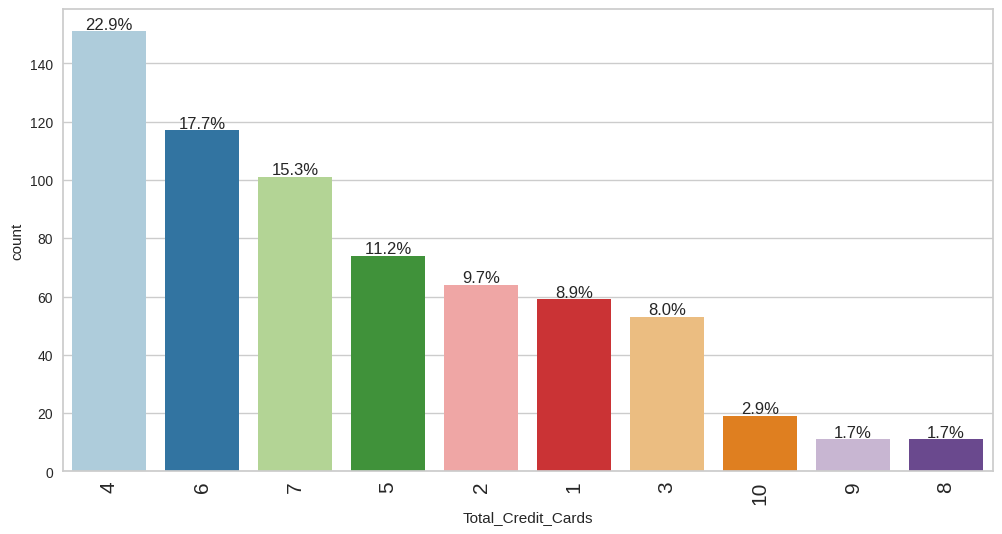

In [119]:
labeled_barplot(df, 'Total_Credit_Cards', perc=True)

- Just below one fifth of the customers have atleast 4 credit cards, while more than eight creditcard holders are at below five percentile.

<ipython-input-118-0aaf8dec4340>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a leng

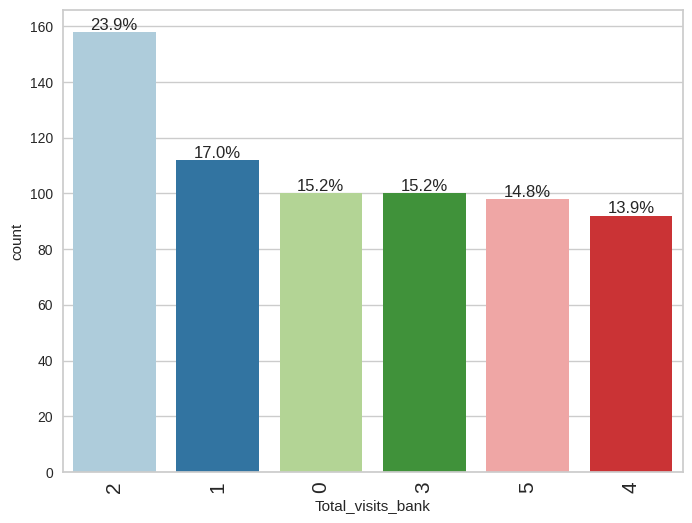

In [120]:
labeled_barplot(df, 'Total_visits_bank', perc=True)

About 24 percentiles of the customers are visiting the bank twice, while other numbers of time visiting are about just below one fifth of the total proportion.

<ipython-input-118-0aaf8dec4340>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a leng

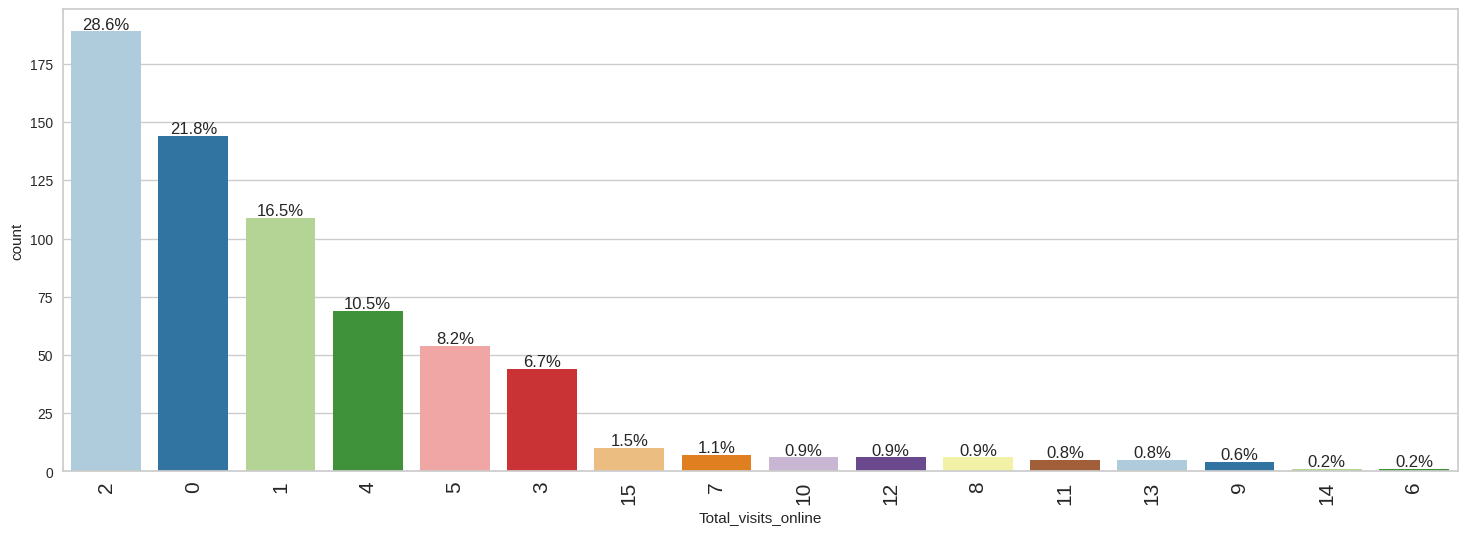

In [121]:
labeled_barplot(df, 'Total_visits_online', perc=True)

<ipython-input-118-0aaf8dec4340>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a leng

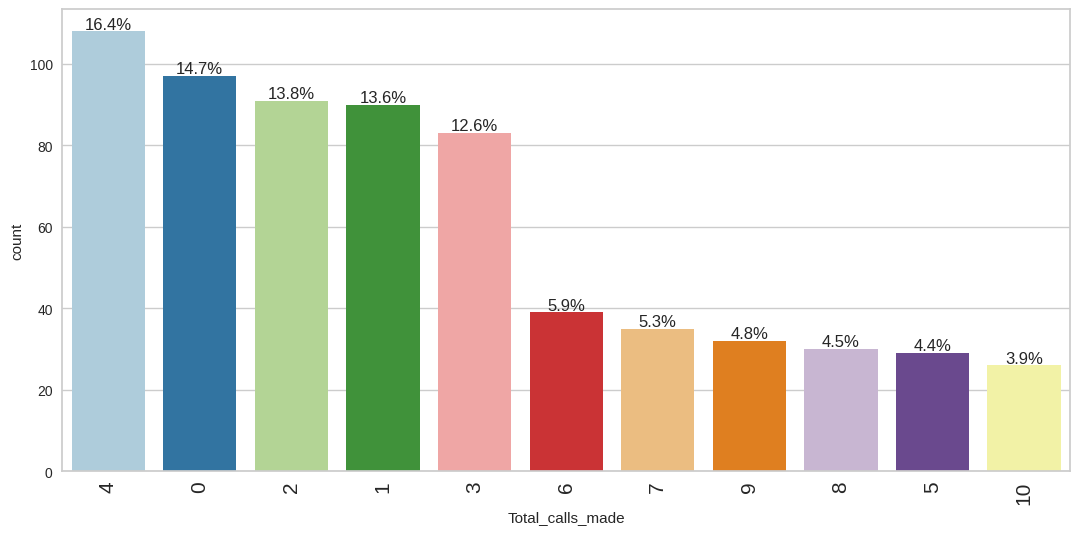

In [122]:
labeled_barplot(df, 'Total_calls_made', perc=True)

**Observations**

- More than 65% of the colleges have a rating less than 4 for placements.
- More than 80% of the colleges have a rating of 3 or more for infrastructure.

### Bivariate Analysis

#### Let's check for correlations

In [123]:
num_col = ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',  'Total_visits_online', 'Total_calls_made']

In [124]:
df1=df[num_col]

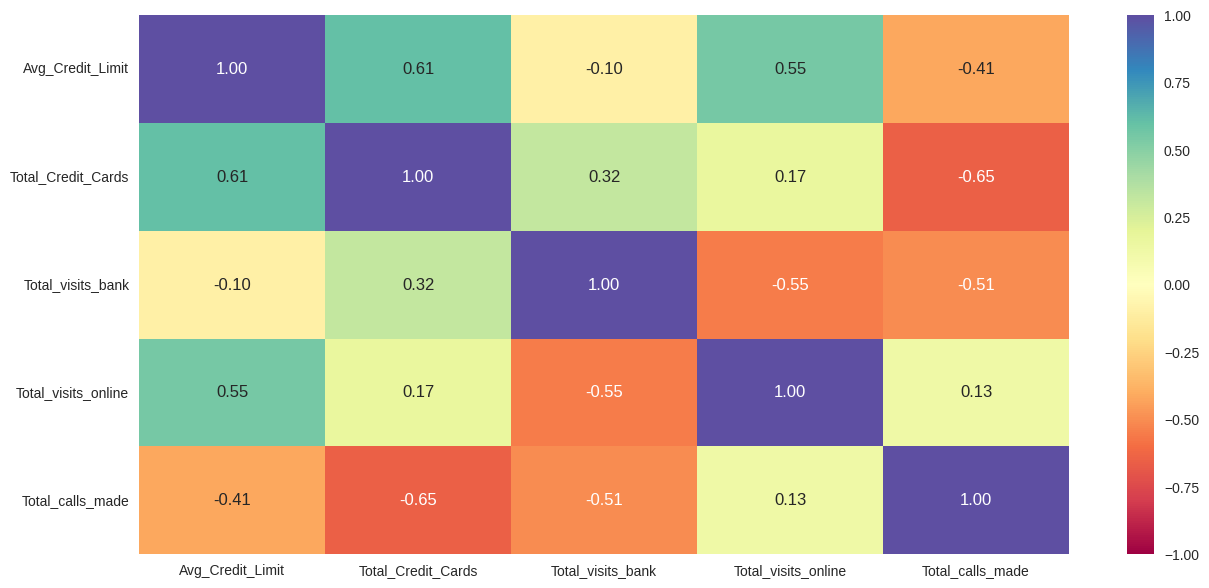

In [125]:
plt.figure(figsize=(15, 7))
sns.heatmap(df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Observation**

- Rating for teaching is strongly positively correlated with the rating for placements and internships.
- This is obvious because if teaching quality is high, students are more likely to get placements and internships.

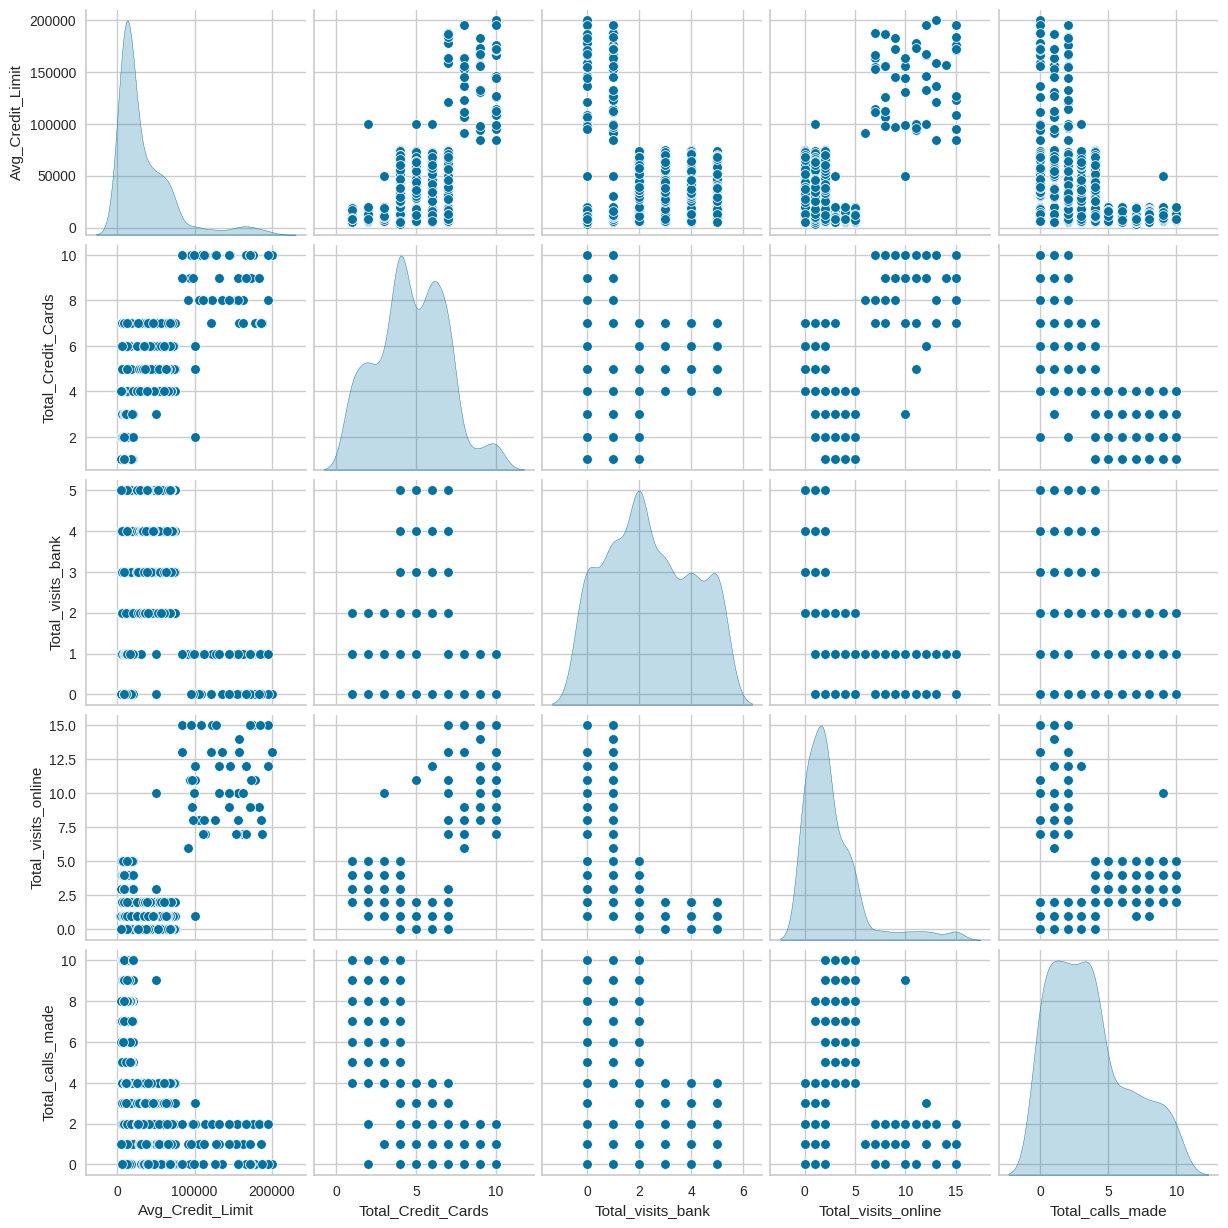

In [126]:
sns.pairplot(data=df[num_col], diag_kind="kde")
plt.show()

**Observations**

- The credit limit is showing very high correlation with the total number of credit cards .More the number of credit card more is the limit. We also noticed that more number of credit card a customer has, he/she tends to visit online site more.
- The total number of credit cards is also positively correlated to number of total visits to bank. High number of credit cards is very highly negatively correlated to total calls made.
- There is a negative correlation between the number of physical visits and total online visits and total calls made. May be this is because physical visits resolve issues which is not followed up by online, phone calls or vice-versa.

## Data Preprocessing

In [127]:
# checking for missing values

df.isnull().sum()

,0
Avg_Credit_Limit,0
Total_Credit_Cards,0
Total_visits_bank,0
Total_visits_online,0
Total_calls_made,0


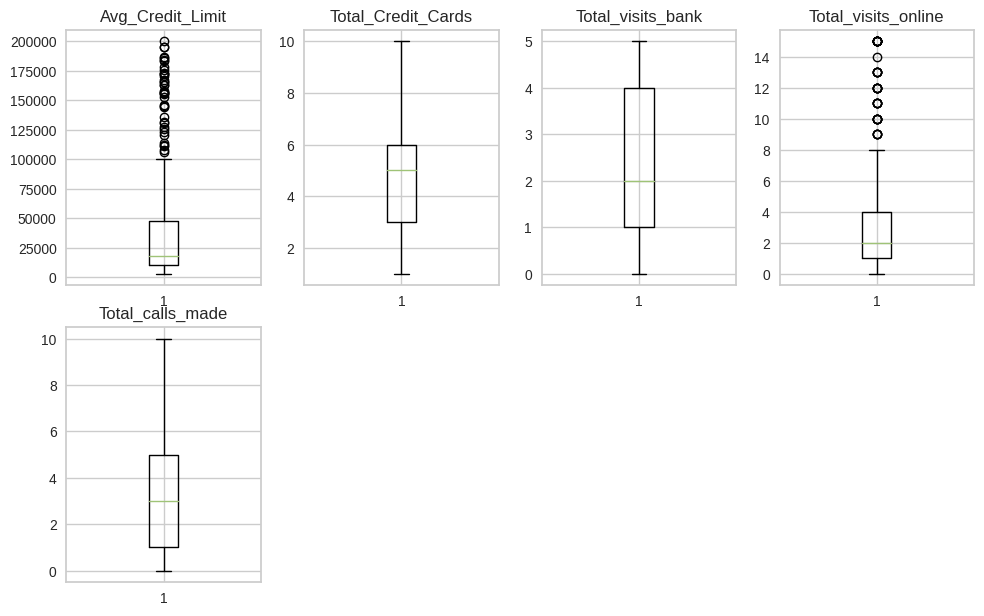

In [128]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(10, 15))

for i, variable in enumerate(num_cols):
    plt.subplot(5, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

In [129]:
# Scaling the data set before clustering
scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

In [130]:
# Creating a dataframe from the scaled data
subset_scaled_Data = pd.DataFrame(subset_scaled, columns=subset.columns)

## K-means Clustering

Number of Clusters: 1 	Average Distortion: 2.006922226250361
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0690158150504387
Number of Clusters: 5 	Average Distortion: 1.0116228163571102
Number of Clusters: 6 	Average Distortion: 0.9866885075923745
Number of Clusters: 7 	Average Distortion: 0.9105773519179009
Number of Clusters: 8 	Average Distortion: 0.888247731637861


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

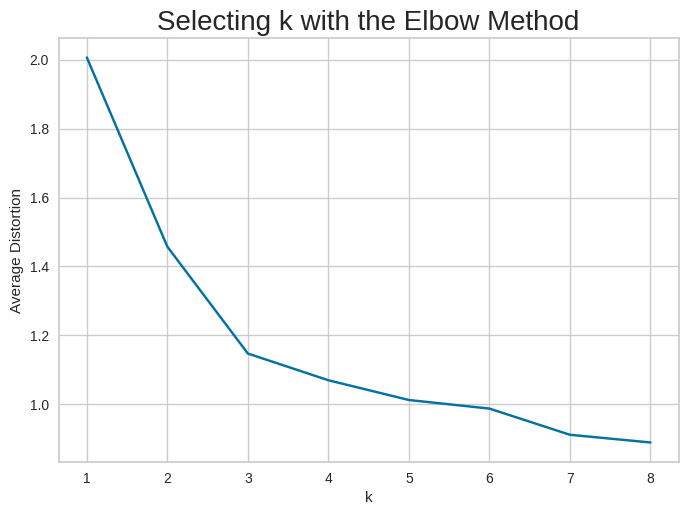

In [131]:
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_Data)
    prediction = model.predict(subset_scaled_Data)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_Data, model.cluster_centers_, "euclidean"), axis=1)
        )
        / df1.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

**The appropriate value of k from the elbow curve seems to be 3 to 5.**

### Let's check the silhouette scores

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.3748350864358813
For n_clusters = 5, silhouette score is 0.27167502160723267
For n_clusters = 6, silhouette score is 0.25141695530077934
For n_clusters = 7, silhouette score is 0.24508243181771477
For n_clusters = 8, silhouette score is 0.2373292667427906
For n_clusters = 9, silhouette score is 0.2269093390909424


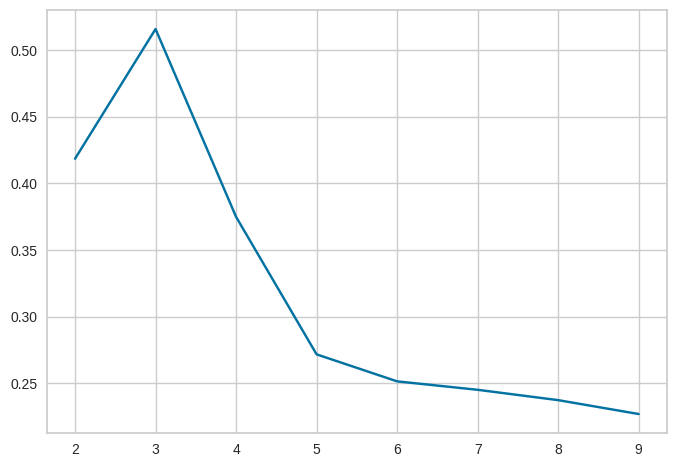

In [132]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_Data))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_Data, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**From the silhouette scores, it seems that 3 is a good value of k.**

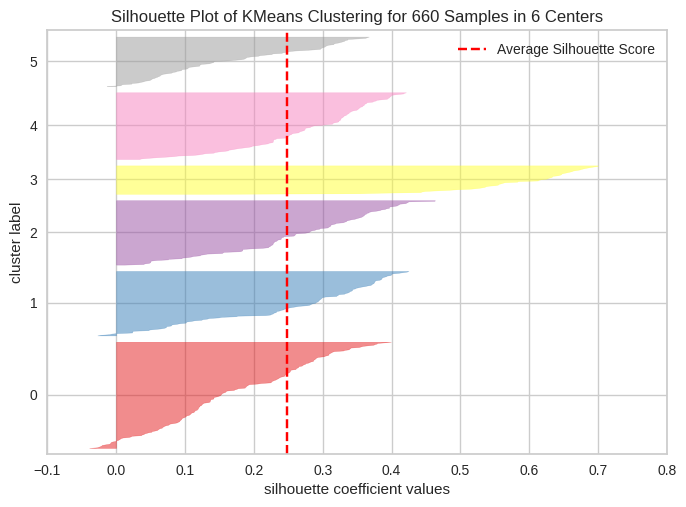

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [133]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))
visualizer.fit(subset_scaled_Data)
visualizer.show()

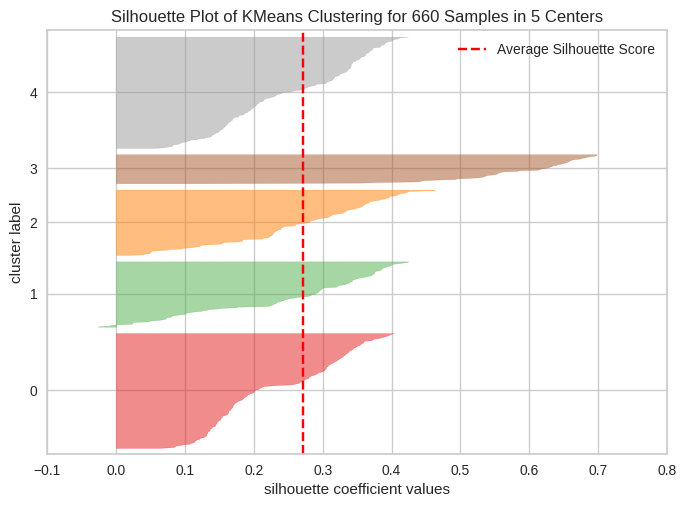

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [134]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(subset_scaled_Data)
visualizer.show()

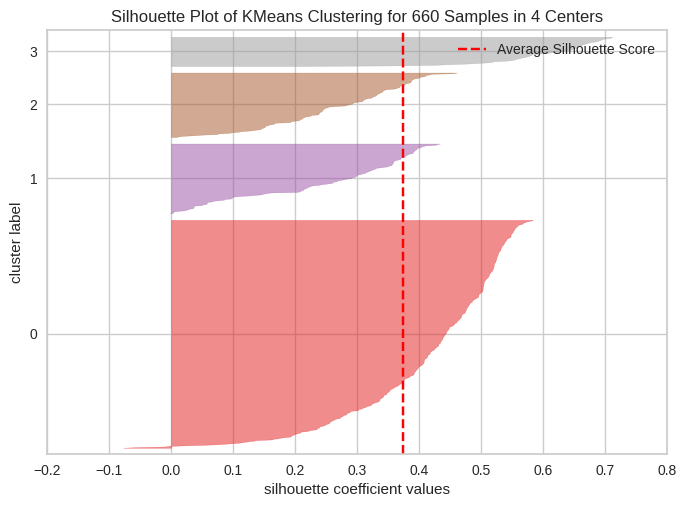

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [135]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_Data)
visualizer.show()

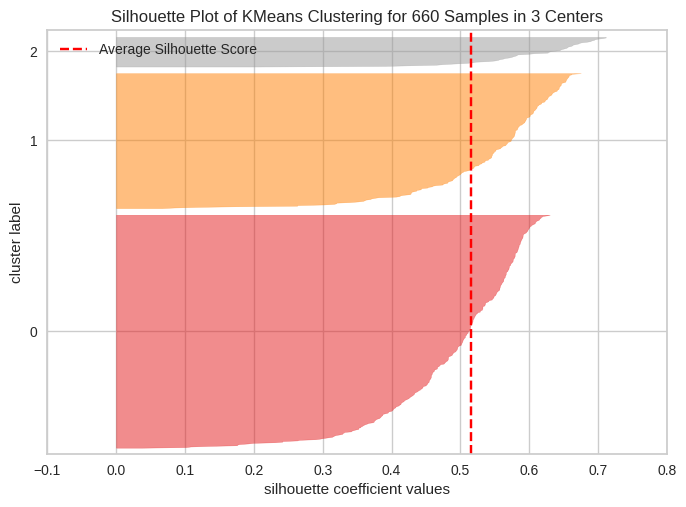

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [136]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_Data)
visualizer.show()

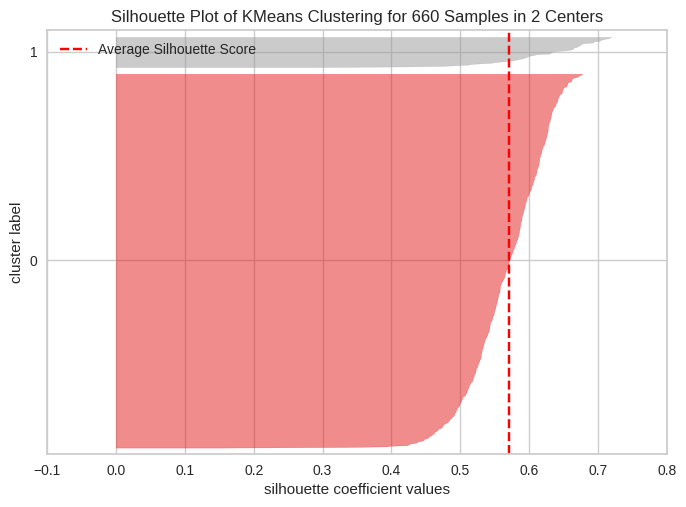

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [137]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(subset_scaled_Data)
visualizer.show()

Silhouette Coefficient is calculated for individual data points, and it tells you how well a single point fits into its cluster.

Silhouette Score is the average of the Silhouette Coefficients for all points in a dataset, providing an overall evaluation of the clustering quality.

We notice that 2 and 3 have the best Silhouette Coefficients but the 3 will be the apt no of coefficients as the density of points is well distributed and there is a nick in the plot.

### Selecting final model

**Let's take 5 as the appropriate no. of clusters as the silhouette score is high enough and there is knick at 5 in the elbow curve.**

In [138]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_Data)

KMeans(n_clusters=3, random_state=0)

In [139]:
# adding kmeans cluster labels to the original dataframe
df["K_means_segments"] = kmeans.labels_

## Cluster Profiling

In [140]:
cluster_profile = df.groupby("K_means_segments").mean(numeric_only = True)

In [141]:
cluster_profile["count_in_each_segment"] = (
    df.groupby("K_means_segments")["Total_Credit_Cards"].count().values
)

In [142]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


**Observation**

We observe that three clusters have given us grouping of 386, 224 and 50 datapoints.

Cluster 0: The cluster has been made based on the grouping datapoints which are based on total visits

Cluster 1: The cluster has been made based on the grouping datapoints which are based on total calls made.

Cluster 2 : This cluster is made based on the grouping of datapoints which are having a higher credit limit, more number of credit cards and more number of online visits. we also noticed during visualisation that a higher credit limit was proportional to more number of credit cards as well as online visits

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.

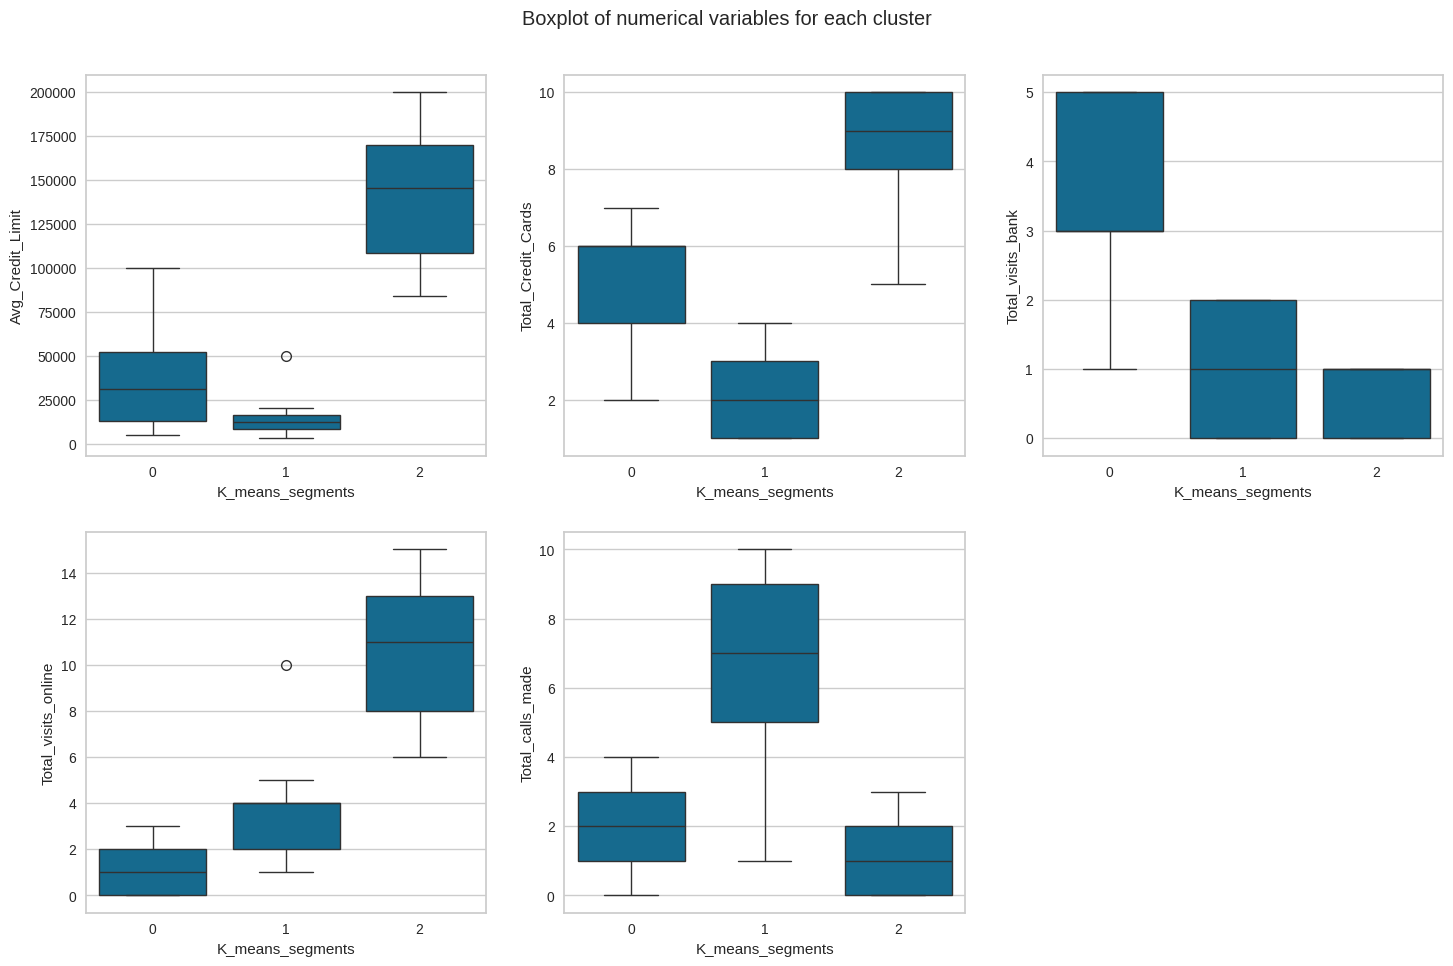

In [143]:
plt.figure(figsize=(15, 10))
plt.suptitle("Boxplot of numerical variables for each cluster")

for i, variable in enumerate(num_col):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=df, x="K_means_segments", y=variable)

plt.tight_layout(pad=2.0)

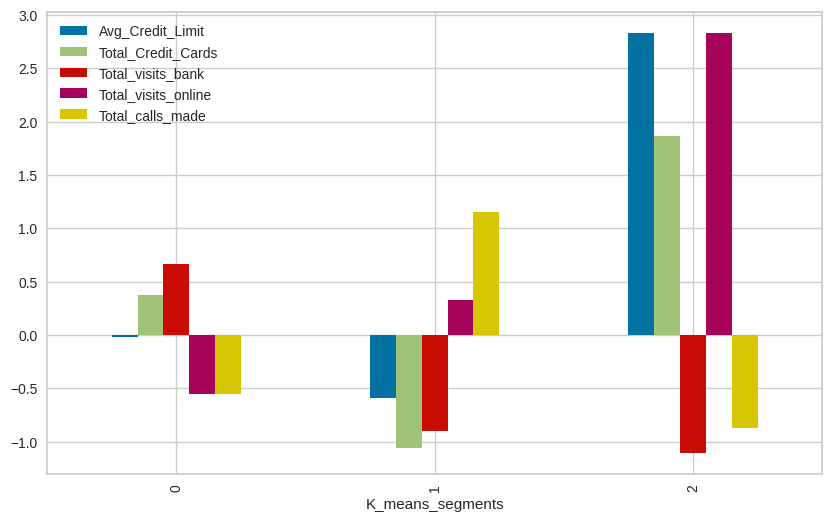

In [144]:
# Apply the scaler to the numeric columns and create a new DataFrame
scaled_data = pd.DataFrame(scaler.fit_transform(df[num_col]), columns=num_col)

# Keep the 'K_means_segments' column in the scaled data
scaled_data['K_means_segments'] = df['K_means_segments']

# Group by 'K_means_segments' and calculate the mean of the scaled data
grouped_data = scaled_data.groupby('K_means_segments').mean()

# Plot the scaled grouped data
grouped_data.plot.bar(figsize=(10, 6))
plt.show()

**Observation:**

1) Avg_credtid_limit : As already discussed the cluster number 2 has the best credit limit between 90000 to 200000. CLuster 1 has the lowest which is in between minimum to 20000.

2) Total_credit_cards: The total number of credit cards is also highest in cluster 2 gruop. Cluster 1 has between 1-4 no of credit cards and cluster 0 has between 2-7.

3) Total_visits_bank : The total visits to the bank was very high in cluster 0. and the lowest in cluster 2. this means people with high credit facility dont prefer visiting banks

4) Total_visits_online : The case with the this parameter is completely in reverse to the total_visits_bank. We notice that the cluster 2 prefer visiting online more followed by cluster 1 and cluster 0,

5) The_total_calls_made: the total calls made was highest in the customers who have a low credit limit. They made between 1 to 10 calls per annum.

## Hierachial Clustering

In [145]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_Data, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_Data))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553606.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.5422791209801751.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042136.
Cophenetic co

In [146]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


**Let's explore different linkage methods with Euclidean distance only.**

In [147]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_Data, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_Data))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


In [148]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


**We see that the cophenetic correlation is maximum with Euclidean distance and average linkage.**

### Checking Dendrograms

**Let's see the dendrograms for the different linkage methods.**

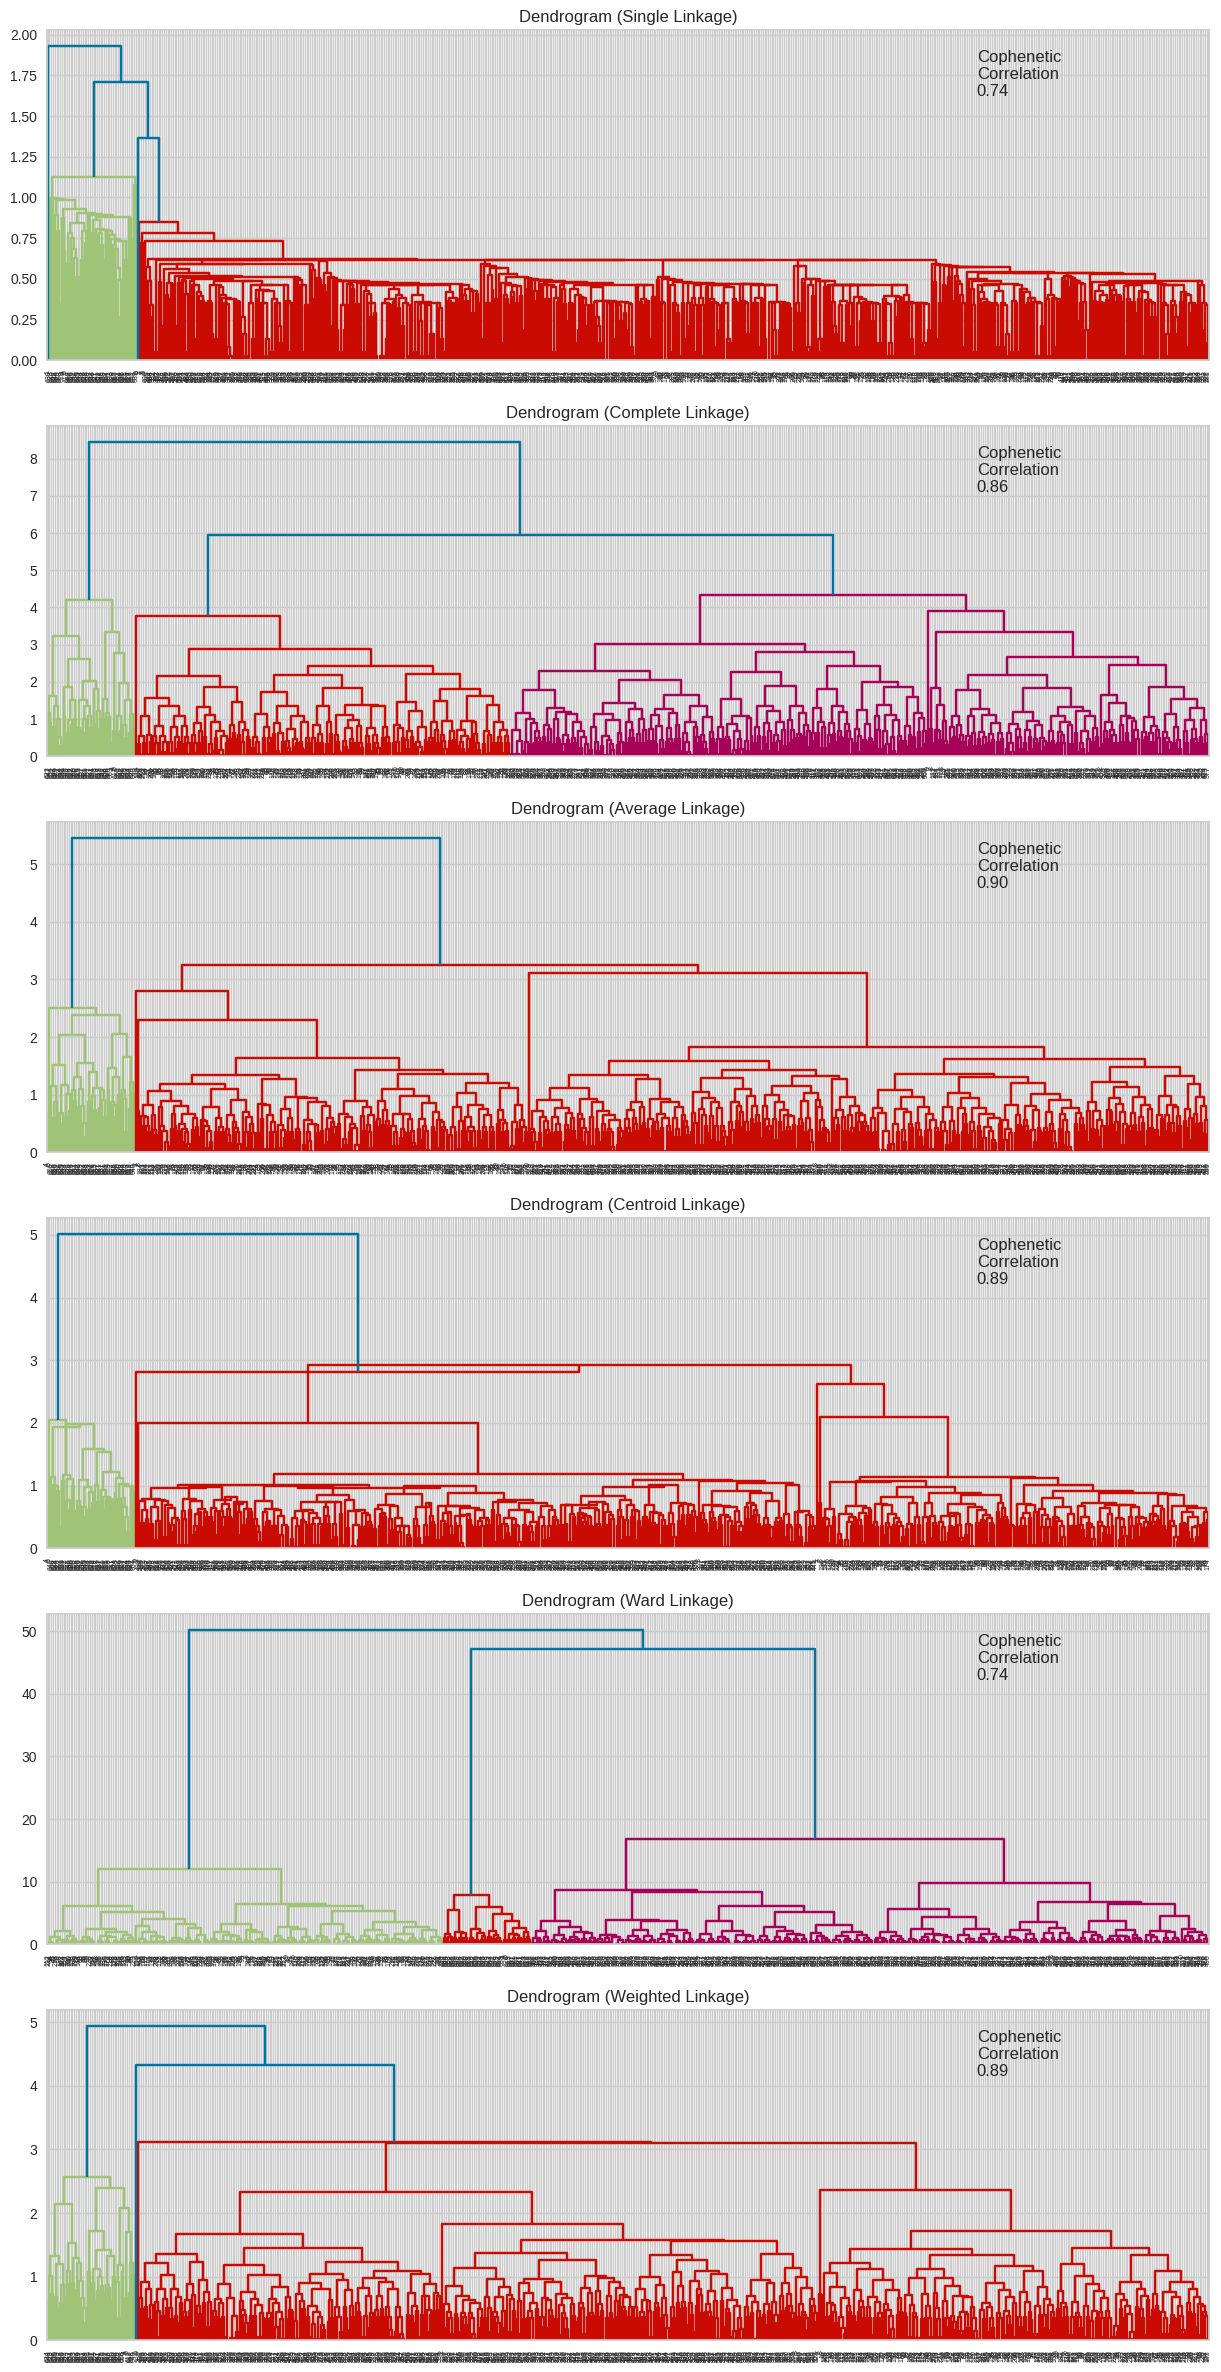

In [149]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_Data, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_Data))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Observations**

The cophenetic correlation is highest for average linkage methods. We will move ahead with average linkage. 3 appears to be the appropriate number of clusters from the dendrogram for average linkage

## Creating Model Using SKlearn

In [150]:
HCmodel = AgglomerativeClustering(n_clusters=3, metric="euclidean", linkage="average")
HCmodel.fit(subset_scaled_Data)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [151]:
subset_scaled_Data["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

In [152]:
HC_cluster_profile = df.groupby("HC_Clusters").mean(numeric_only = True)

In [153]:
HC_cluster_profile["count_in_each_segments"] = (
    df.groupby("HC_Clusters")['Avg_Credit_Limit'].count().values
)

In [154]:
for cl in df["HC_Clusters"].value_counts():
    print("In cluster {}, the following customers are present:".format(cl))
    print(df[df["HC_Clusters"] == cl]["Avg_Credit_Limit"].value_counts())
    print()

In cluster 387, the following customers are present:
Series([], Name: count, dtype: int64)

In cluster 223, the following customers are present:
Series([], Name: count, dtype: int64)

In cluster 50, the following customers are present:
Series([], Name: count, dtype: int64)



In [155]:
# lets display cluster profile
HC_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,0.002584,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,1.000000,223


**Observation**

There are three clusters which have been separted.

Observation

We observe that three clusters have given us grouping of 387, 50 and 223 datapoints.

Cluster 0: The cluster has been made based on the grouping datapoints which are based on total visits

Cluster 1 : This cluster is made based on the grouping of datapoints which are having a higher credit limit, more number of credit cards and more number of online visits. we also noticed during visualisation that a higher credit limit was proportional to more number of credit cards as well as online visits

Cluster 2: The cluster has been made based on the grouping datapoints which are based on total calls made.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.

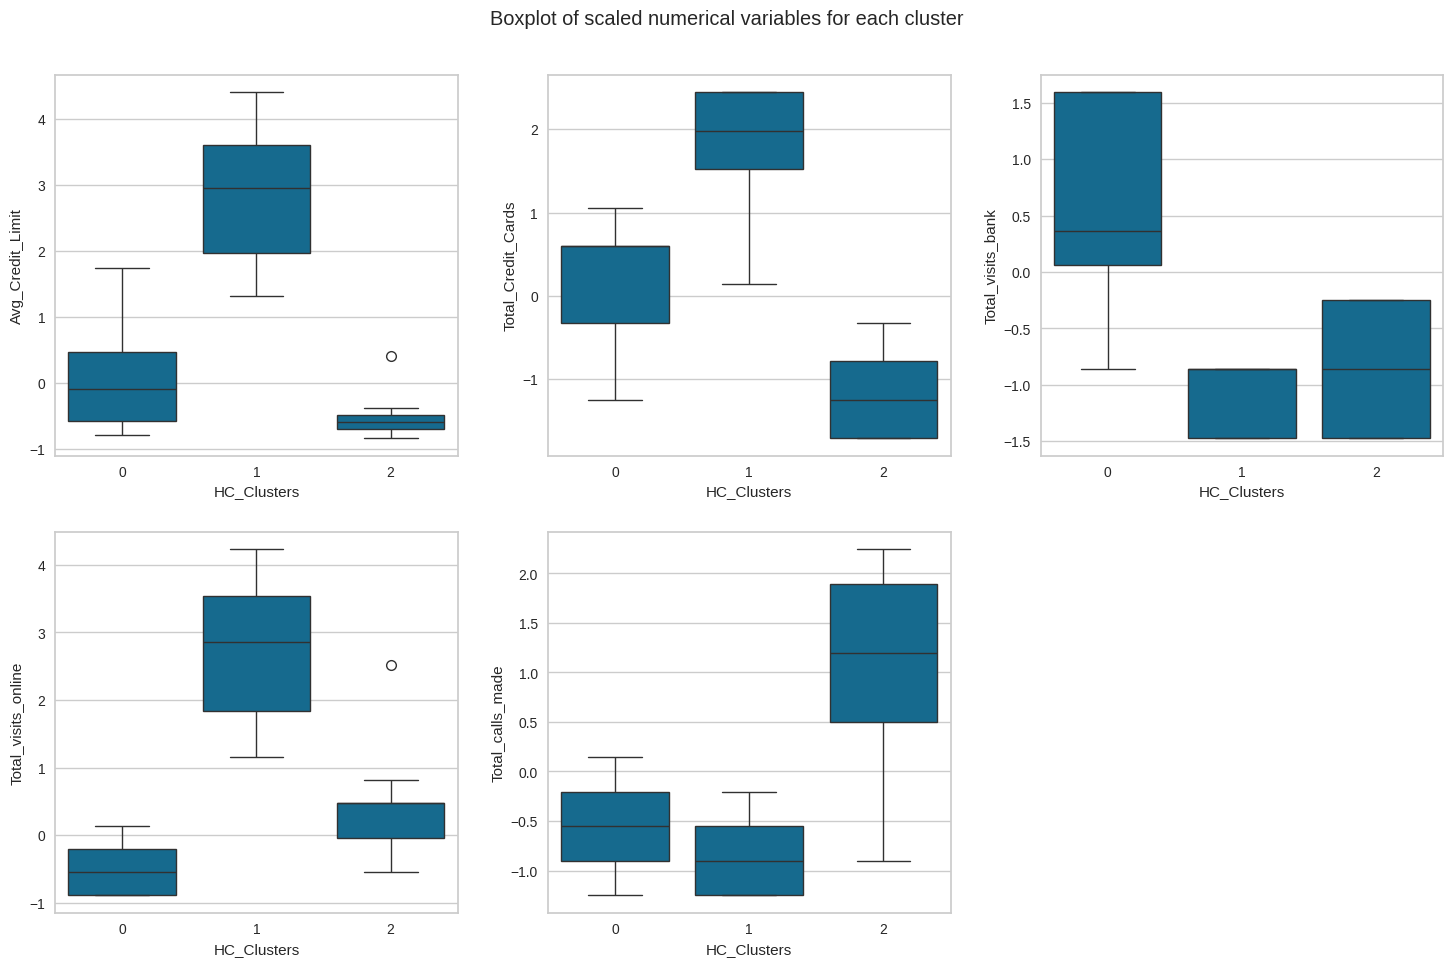

In [156]:
plt.figure(figsize=(15, 10))
plt.suptitle("Boxplot of scaled numerical variables for each cluster")

for i, variable in enumerate(num_col):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=subset_scaled_Data, x="HC_Clusters", y=variable)

plt.tight_layout(pad=2.0)

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.

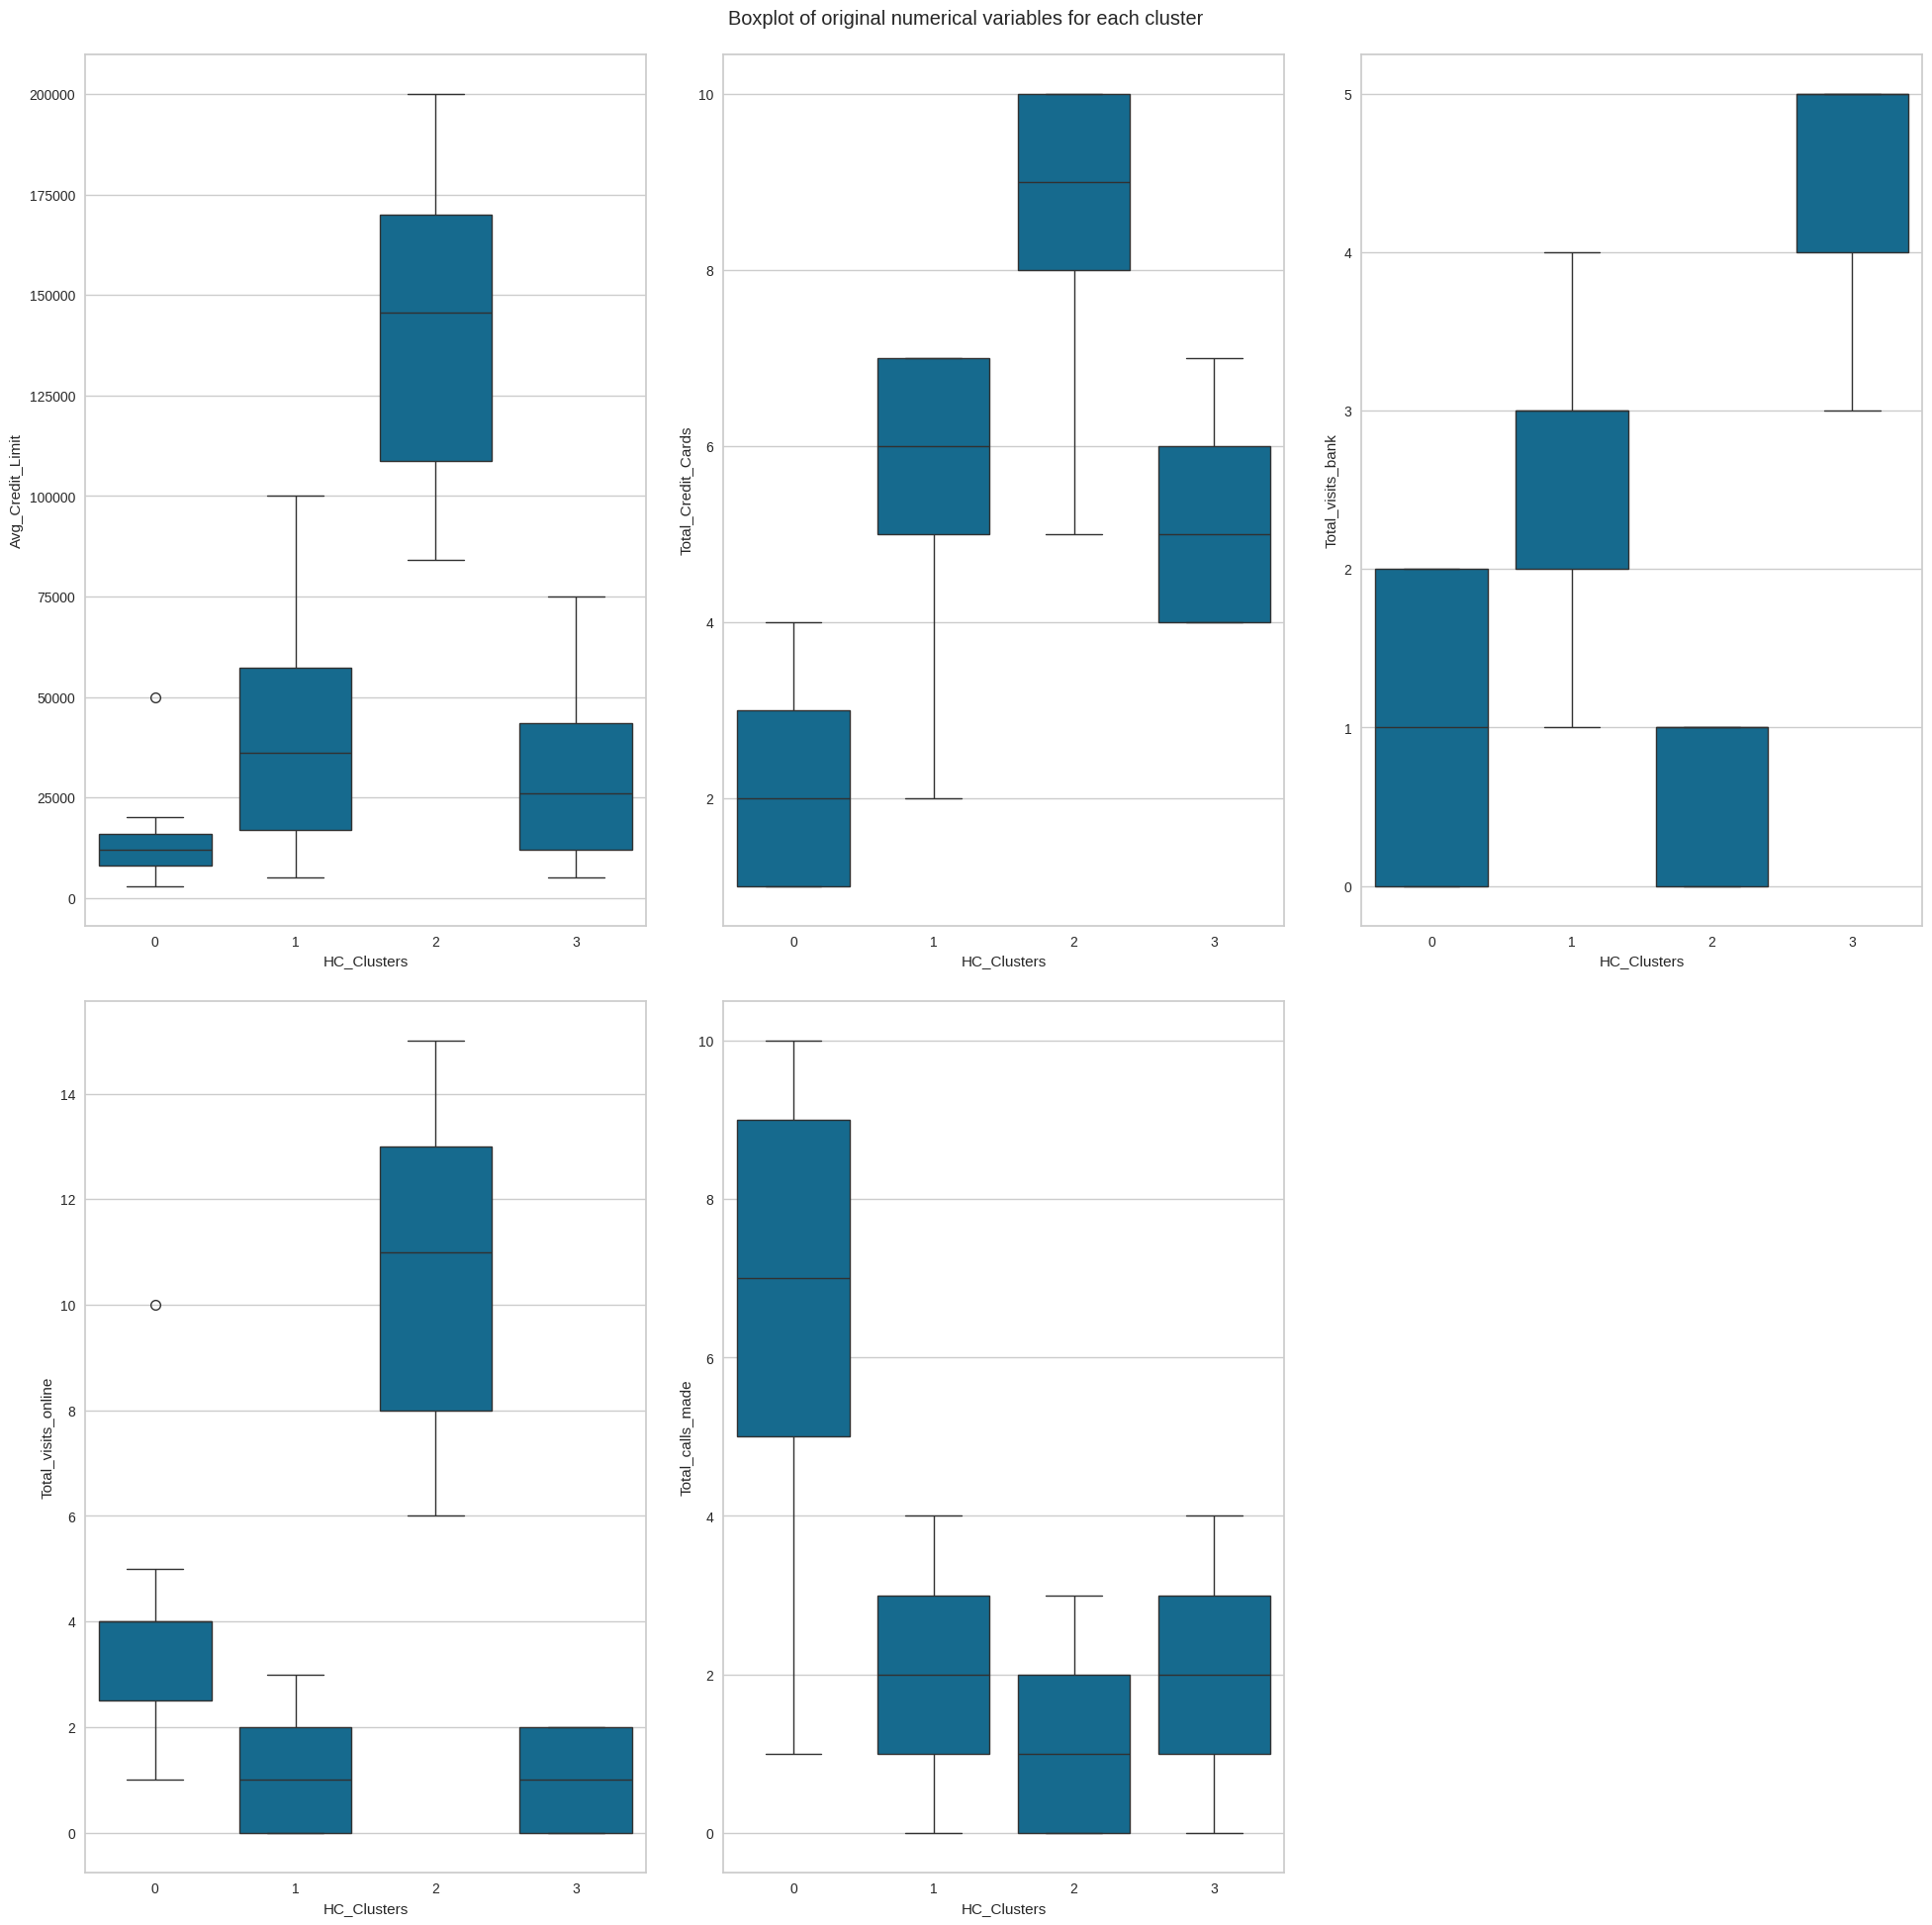

In [166]:
plt.figure(figsize=(20, 20))
plt.suptitle("Boxplot of original numerical variables for each cluster")

for i, variable in enumerate(num_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data= df, x="HC_Clusters", y=variable)

plt.tight_layout(pad=2.0)

**Observation:**

1) Avg_credtid_limit : As already discussed the cluster number 1 has the best credit limit between 90000 to 200000. CLuster 2 has the lowest which is in between minimum to 20000.

2) Total_credit_cards: The total number of credit cards is also highest in cluster 1 gruop. Cluster 2 has between 1-4 no of credit cards and cluster 0 has between 2-7.

3) Total_visits_bank : The total visits to the bank was very high in cluster 0. and the lowest in cluster 1. this means people with high credit facility dont prefer visiting banks

4) Total_visits_online : The case with the this parameter is completely in reverse to the total_visits_bank. We notice that the cluster 1 prefer visiting online more followed by cluster 1 and cluster 0,

5) The_total_calls_made: the total calls made was highest in the customers who have a low credit limit which is cluster 2 . They made between 1 to 10 calls per annum.

Observation

To bring in some more variability we can try using Ward linkage method. Even if the cophenetic correlation is high we can check if ward method is clustering the data differently or not. Hence as per the dendrogram lets try with 4 clusters in Ward Linkage method as the clusters are well separated

In [158]:
HCmodel = AgglomerativeClustering(n_clusters=4, metric="euclidean", linkage="ward")
HCmodel.fit(subset_scaled_Data)

AgglomerativeClustering(n_clusters=4)

In [159]:
subset_scaled_Data["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

In [160]:
cluster_profile = df.groupby("HC_Clusters").mean(numeric_only = True)

In [161]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("HC_Clusters")['Avg_Credit_Limit'].count().values
)

In [162]:
# lets display cluster profile
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,
0,12197.309417,2.403587,0.928251,3.560538,6.883408,1.000000,223
1,37520.408163,5.642857,2.525510,0.974490,2.142857,0.005102,196
2,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50
3,29806.282723,5.376963,4.471204,0.994764,1.863874,0.000000,191


**Observation**

We observe the below

Cluster 0 : the average total visit is the highest amongst the customer base.

Cluster 1 : the cluster 1 is not having anything which is high in any parameter. we can consider that this set of customer are having less avg number of credit cards which is 5 and visit almost equally more the bank.

CLuster 2 : This is the cream customer of the bank which have high credit limit and highest avg credit cards. They also tend to visit online more.

Cluster 3 : The average calls made is the highest in this group.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.

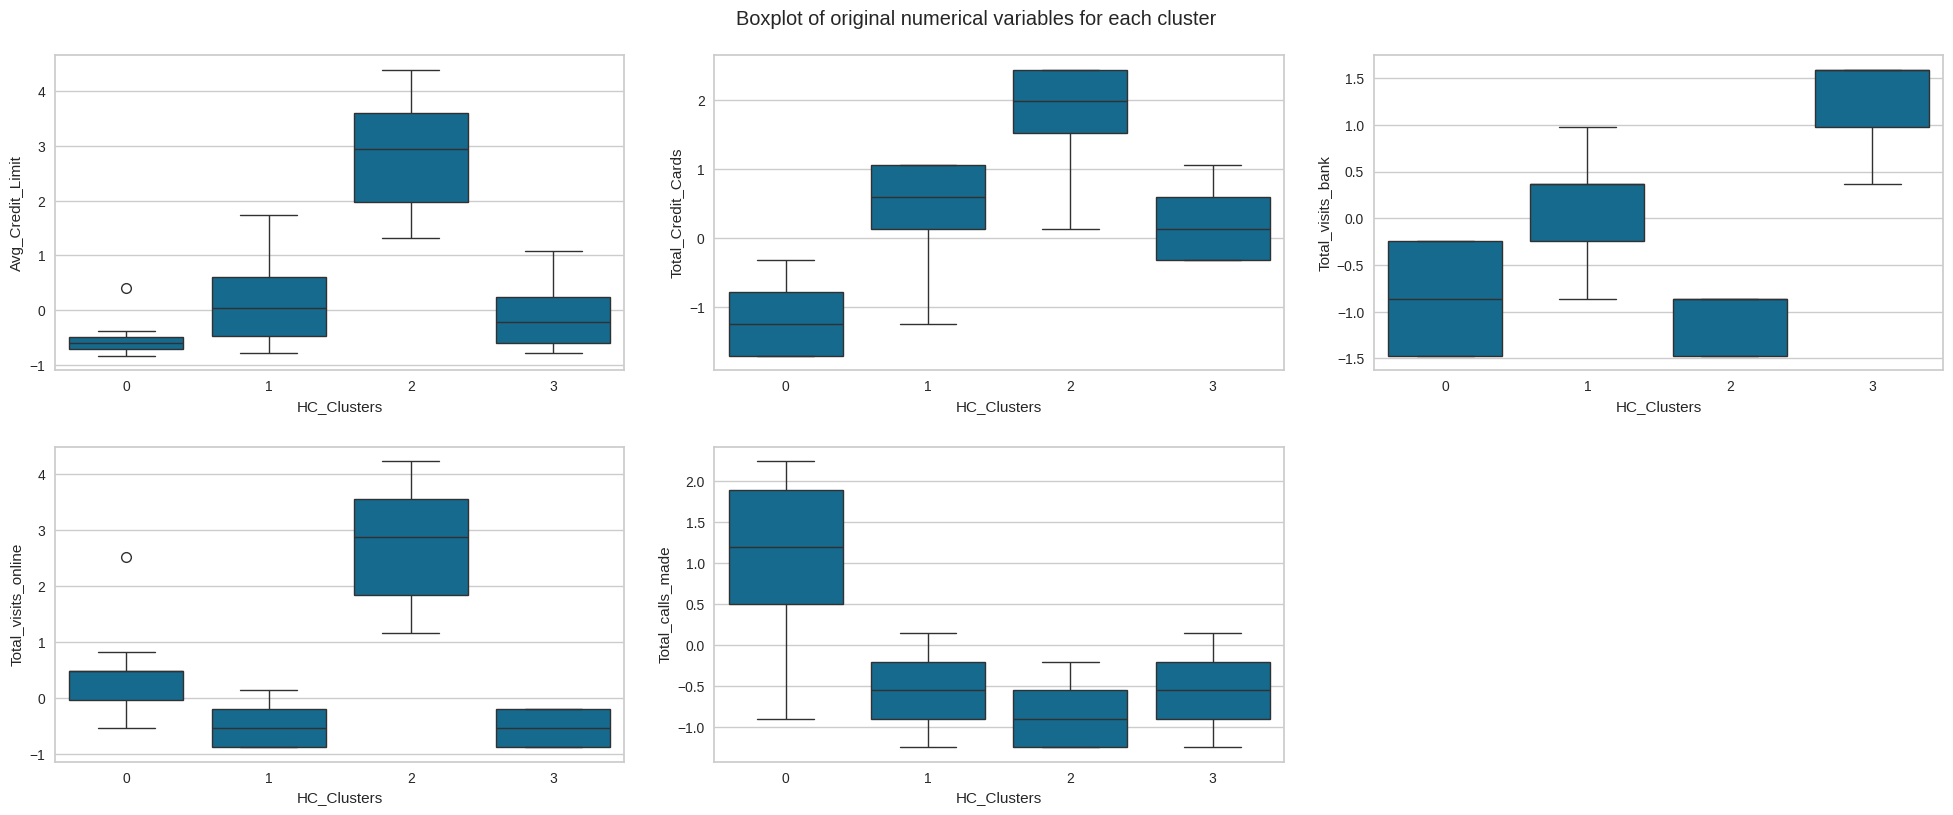

In [165]:
plt.figure(figsize=(20,15))
plt.suptitle("Boxplot of original numerical variables for each cluster")

for i, variable in enumerate(num_cols):
    plt.subplot(5, 3, i + 1)
    sns.boxplot(data= subset_scaled_Data, x="HC_Clusters", y=variable)

plt.tight_layout(pad=2.0)

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.

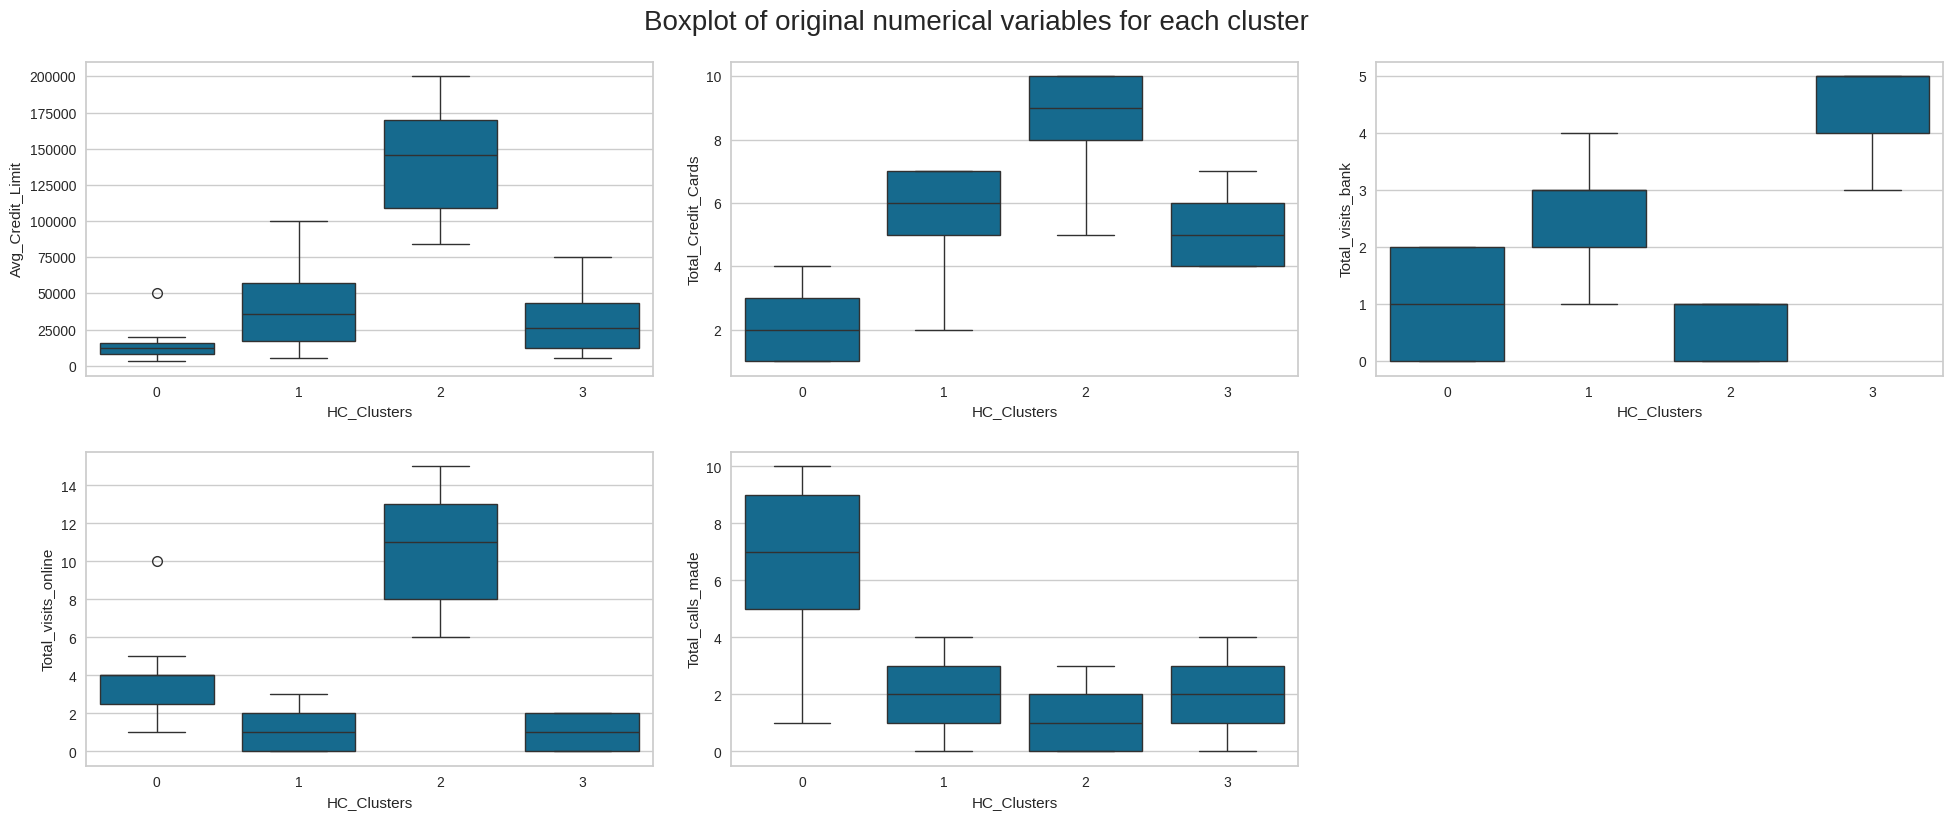

In [164]:
plt.figure(figsize=(20, 15))
plt.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)

for i, variable in enumerate(num_cols):
    plt.subplot(5, 3, i + 1)
    sns.boxplot(data=df, x="HC_Clusters", y=variable)

plt.tight_layout(pad=2.0)

**Observation**

We observe the below

Avg_Credit Limit : As we can observe the average credit limit is the highest in the cluster 2 group and lowest in cluster 0

Total credit cards : The total credit cards also is the highest in the cluster 2 group

Total visits to bank : the cluster 3 and 1 are having a good number of visits to the bank every annum.

Total visits online :  Customers who have high credit limit and more number of cards tend to visit online more.

Total calls made   : the total calls made is the highest in the cluster 0 group and lowest in the cluster 2 group.


**Observation on Ward Linkage**

We notice that Ward linkage is not able to cluster the data better than the other methods so we can conclude that average linkage with 3 clusters is the best option.  

## Business Insights and  Recommendations

- **Cluster 0**: These are the Tier 1 Colleges and have excellent teaching, placements & internships while maintaining a moderate infrastructure and moderate fees. **Corporates looking for the best candidates can approach this cluster for placements and internships.**


- **Cluster 2**: These are the Tier 2 Colleges which are just behind the Tier 1 colleges in terms of teaching and placements, but provide quite better infrastructure and are accordingly more expensive. **They have scope for improvements in teaching, placements, and internships, and should consider tie-ups with corporates and ed-tech and training organizations. Companies providing training programs to faculty and students should approach them.**


- **Cluster 3**: These are the Tier 3 colleges which have very high fees and very good infrastructure, but do not offer proper value-for-money in terms of teaching and internships. **This cluster of colleges will need to concentrate more towards onboarding better faculty and securing tie-ups with corporates to improve placement opportunities.**


- **Cluster 1** and **Cluster 4**: These are the poor performing colleges or new colleges. **These colleges will need to concentrate more on marketing and advertisements about their offerings to create awareness and attract students.**

___